In [3]:
import networkx as nx
import pandas as pd
from functools import reduce
import numpy as np
from enum import Enum

edge_df = pd.read_csv('backlink_weights.csv')
edge_df.reset_index(inplace=True)
edge_df['domain_from'] = edge_df['domain_from'].str.lower()
edge_df['domain_to'] = edge_df['domain_to'].str.lower()
attrs = ['links','unique_pages', 'tb_ratio','so_ratio', 'e_tb_ratio','e_so_ratio','tp_ratio', 'sp_ratio']
node_mapping = {k: v for v, k in enumerate(set(list(edge_df.domain_from.unique()) + list(edge_df.domain_to.unique())))}

edge_df['domain_from_idx'] = edge_df.domain_from.map(node_mapping)
edge_df['domain_to_idx'] = edge_df.domain_to.map(node_mapping)

G = nx.from_pandas_edgelist(edge_df, source='domain_from_idx', target='domain_to_idx', edge_attr=attrs, create_using=nx.DiGraph())

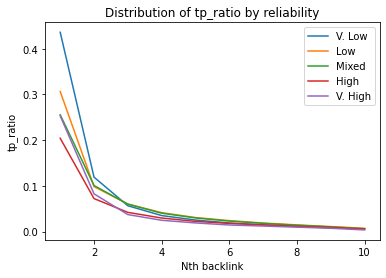

In [4]:
from scipy.stats import entropy
import itertools
import matplotlib.pyplot as plt

targets = list(edge_df.domain_to.unique())
inv_node_mapping = {v: k for k, v in node_mapping.items()}

dists = {}
weight_scheme = 'tp_ratio'

for target in targets:
    current_node = node_mapping[target]
    preds = list(G.predecessors(current_node))
    # for neighbor in preds:
    #     print(G.get_edge_data(current_node, neighbor))
    dist = [G.get_edge_data(neighbor, current_node)[weight_scheme] for neighbor in preds]
    dist.sort(reverse=True)
    dists[target] = dist#dist.items(), key=lambda x: x[1], reverse=True)

dists_df = pd.DataFrame.from_dict(dists, orient='index')

dists_df.rename(columns={0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:8, 8:9, 9:10}, inplace=True)

url_df = pd.read_csv('../data/filtered_attrs.csv')
url_df['url'] = url_df['url'].str.lower()
url_df = url_df[['url','label']]
labelled_dists = pd.merge(dists_df, url_df, left_index=True, right_on='url')

fig, ax = plt.subplots()
labelled_dists.groupby('label').mean().transpose().plot(ax=ax)
ax.set_title('Distribution of ' + weight_scheme + ' by reliability')
ax.set_ylabel(weight_scheme)
ax.set_xlabel('Nth backlink')
ax.legend(['V. Low', 'Low', 'Mixed', 'High', 'V. High'])